In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
from pathlib import Path
import os

PROJECT_ROOT = Path("/content/drive/MyDrive/Stock Project").resolve()
os.chdir(PROJECT_ROOT)

print("CWD =", Path.cwd())
print("Files here:", [p.name for p in Path.cwd().iterdir()])

CWD = /content/drive/MyDrive/Stock Project
Files here: ['01_price_data_baseline.ipynb', '02_feature_engineering.ipynb']


In [48]:
"""
Goal:
- Load clean historical price data
- Compute returns
- Establish a buy-and-hold baseline
- Measure drawdowns and volatility

This notebook intentionally contains:
- No ML
- No sentiment
- No strategy optimization
"""

'\nGoal:\n- Load clean historical price data\n- Compute returns\n- Establish a buy-and-hold baseline\n- Measure drawdowns and volatility\n\nThis notebook intentionally contains:\n- No ML\n- No sentiment\n- No strategy optimization\n'

In [49]:
import os
import warnings
from dataclasses import dataclass
from typing import List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 50)

In [50]:
import yfinance as yf

In [51]:
@dataclass
class Config:
    tickers: List[str]
    start: str = "2010-01-01"
    end: Optional[str] = None   # None = today
    interval: str = "1d"
    auto_adjust: bool = True    # adjusts for splits/dividends

cfg = Config(
    tickers=["SPY"],
    start="2010-01-01"
)

cfg

Config(tickers=['SPY'], start='2010-01-01', end=None, interval='1d', auto_adjust=True)

In [52]:
def download_prices(cfg: Config) -> pd.DataFrame:
    df = yf.download(
        tickers=cfg.tickers,
        start=cfg.start,
        end=cfg.end,
        interval=cfg.interval,
        auto_adjust=cfg.auto_adjust,
        group_by="column",
        progress=False,
        threads=True,
    )
    if df is None or df.empty:
        raise ValueError("No data downloaded.")
    return df

raw = download_prices(cfg)
raw.head()

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2010-01-04,85.027985,85.072999,83.662495,84.307727,118944600
2010-01-05,85.253036,85.290552,84.667828,84.975441,111579900
2010-01-06,85.313034,85.523108,85.102960,85.170481,116074400
2010-01-07,85.673180,85.778217,84.915407,85.155492,131091100
2010-01-08,85.958298,85.995813,85.275556,85.448115,126402800


In [53]:
def to_close_wide(df: pd.DataFrame, tickers: List[str]) -> pd.DataFrame:
    # Multi-ticker case → MultiIndex columns
    if isinstance(df.columns, pd.MultiIndex):
        close = df["Close"].copy()
    else:
        # Single ticker → plain columns
        close = df[["Close"]].copy()
        close.columns = tickers

    close.index = pd.to_datetime(close.index)
    close = close.sort_index()
    return close

prices = to_close_wide(raw, cfg.tickers)
prices.head()

Ticker,SPY
Date,
2010-01-04,85.027985
2010-01-05,85.253036
2010-01-06,85.313034
2010-01-07,85.673180
2010-01-08,85.958298


In [54]:
# Index must be increasing
assert prices.index.is_monotonic_increasing

# Remove duplicate timestamps if any
prices = prices[~prices.index.duplicated(keep="first")]

# Missingness check
missing_pct = prices.isna().mean().sort_values(ascending=False)
missing_pct

,0
Ticker,
SPY,0.0


In [55]:
# Forward-fill short gaps only
prices_ffill = prices.ffill(limit=5)

# Do NOT fill leading NaNs
prices_ffill.isna().sum()

,0
Ticker,
SPY,0


In [56]:
returns = prices_ffill.pct_change().dropna(how="all")

summary = pd.DataFrame({
    "start": [prices_ffill.index.min()],
    "end": [prices_ffill.index.max()],
    "n_obs": [len(prices_ffill)],
    "ann_vol_est": [returns.std().mean() * np.sqrt(252)]
})

summary

,start,end,n_obs,ann_vol_est
0,2010-01-04,2026-01-02,4025,0.172076


In [57]:
stats = pd.DataFrame({
    "mean_daily_return": returns.mean(),
    "std_daily_return": returns.std(),
    "ann_return_approx": returns.mean() * 252,
    "ann_vol": returns.std() * np.sqrt(252),
    "min_daily_return": returns.min(),
    "max_daily_return": returns.max(),
})

stats

,mean_daily_return,std_daily_return,ann_return_approx,ann_vol,min_daily_return,max_daily_return
Ticker,,,,,,
SPY,0.000577,0.01084,0.145369,0.172076,-0.109423,0.105019


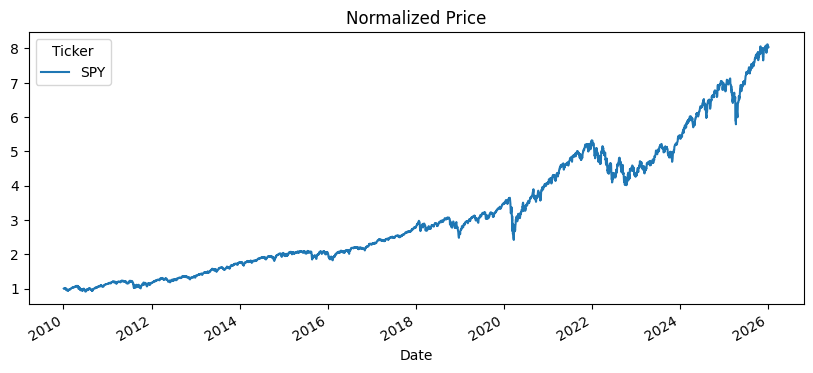

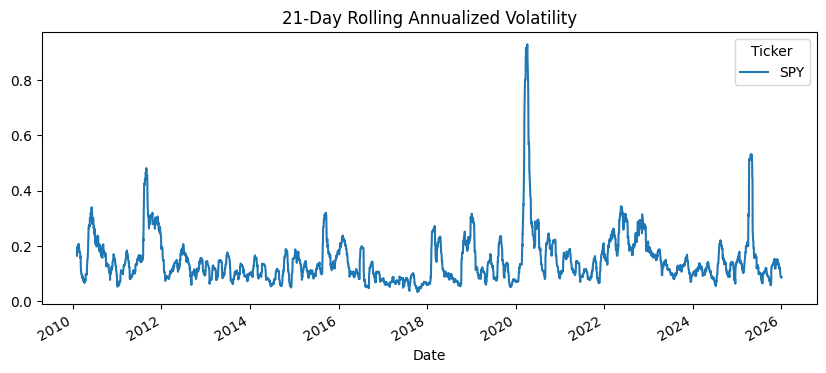

In [58]:
# Normalized price
(prices_ffill / prices_ffill.iloc[0]).plot(figsize=(10,4))
plt.title("Normalized Price")
plt.show()

# Rolling volatility
returns.rolling(21).std().mul(np.sqrt(252)).plot(figsize=(10,4))
plt.title("21-Day Rolling Annualized Volatility")
plt.show()

In [59]:
os.makedirs("data", exist_ok=True)

prices_ffill.to_parquet("data/clean_prices.parquet")
returns.to_parquet("data/returns.parquet")

print("Saved:")
print("data/clean_prices.parquet")
print("data/returns.parquet")

Saved:
data/clean_prices.parquet
data/returns.parquet


In [60]:
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

prices_ffill.to_parquet(DATA_DIR / "clean_prices.parquet")
returns.to_parquet(DATA_DIR / "returns.parquet")

print("Saved:", list(DATA_DIR.iterdir()))

Saved: [PosixPath('data/clean_prices.parquet'), PosixPath('data/returns.parquet')]


In [61]:
"""
Status: Frozen.
Purpose: Baseline reference for all future strategies.

"""

'\nStatus: Frozen.\nPurpose: Baseline reference for all future strategies.\n\n'